#### SQAE with DRC 

Trying the Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import QAE_pennylane as pQAE

import warnings
warnings.filterwarnings('ignore')

2022-09-23 17:55:47.787453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 17:55:47.787470: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### data 

In [2]:
test = h5py.File("../../data/small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_s[:],
                                                  y_s[:],
                                                  test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [4]:
x_train_1 = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_1 = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_1 = x_test[y_test==1]
x_test = x_test[y_test==0]

In [5]:
div = np.max(x_train_1,axis=(1,2)).reshape(x_train_1.shape[0],1,1)
div[div == 0] = 1
x_train_1 = x_train_1 / div
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_val_1,axis=(1,2)).reshape(x_val_1.shape[0],1,1)
div[div == 0] = 1
x_val_1 = x_val_1 / div
div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1)
div[div == 0] = 1
x_val = x_val / div

div = np.max(x_test_1,axis=(1,2)).reshape(x_test_1.shape[0],1,1)
div[div == 0] = 1
x_test_1 = x_test_1 / div
div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1)
div[div == 0] = 1
x_test = x_test / div

# Circuit

In [6]:
LATENT_QBITS = 5
DRCs = 2
EPOCHS = 10

DATA_QBITS = 9
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 12

In [7]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [8]:
model = pQAE.ConvSQAE(DATA_QBITS,
                         LATENT_QBITS, 
                         dev1, 
                         INPUT_DATA_SIZE, 
                         kernel_size=4, 
                         stride=4, 
                         DRCs=DRCs, 
                         diff_method="adjoint")

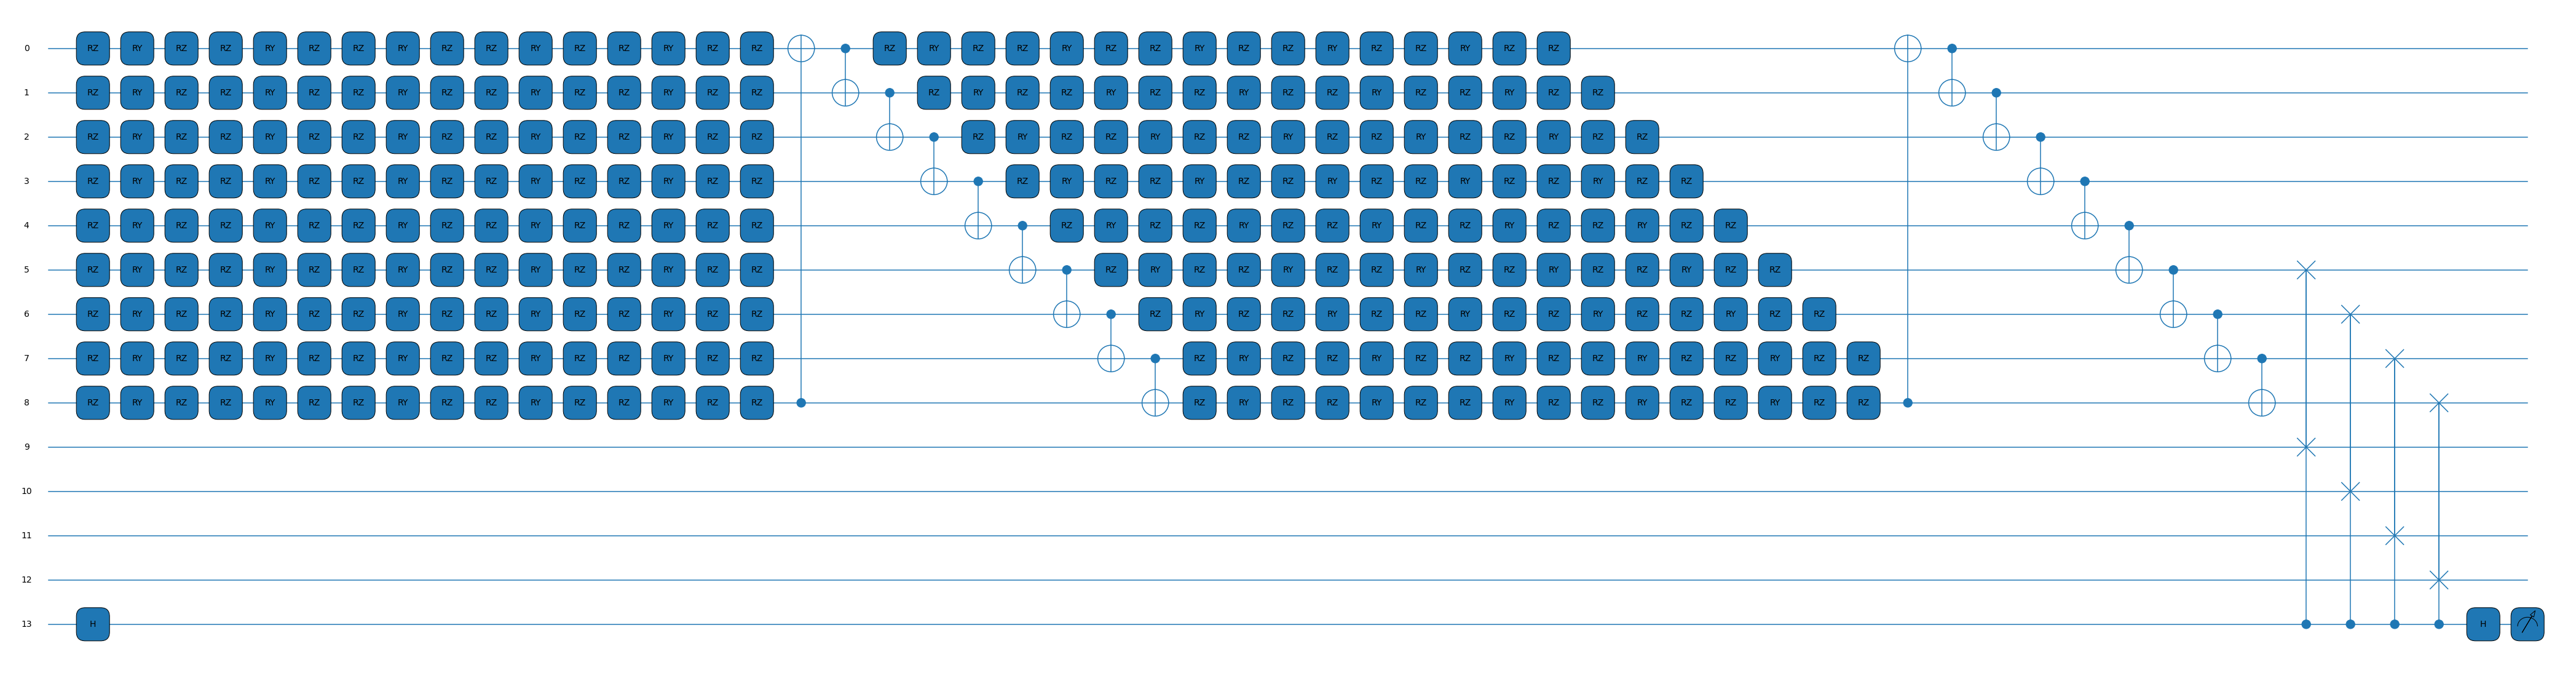

In [9]:
model.plot_circuit()

In [10]:
x_train_small = x_train[:5000]
x_train_1_small = x_train_1[:5000]
x_test_small = x_test[:1200]
x_test_1_small = x_test_1[:1200]

In [11]:
model.train(x_train_1_small, x_test_1_small, 
            learning_rate=0.01, 
            epochs=EPOCHS, 
            batch_size=30, 
            print_step_size=100, 
            make_animation=False,
            save_auc=True,
            x_val_signal=x_test_small)

Step: 100     | Loss: 0.00182    | avg step time 4.17 | avg gradient 0.44
____
Epoch: 0     | Loss: 0.000824   | Val Loss 0.000755
____



KeyboardInterrupt



In [ ]:
model.evaluate(x_test_1_small, x_test_small)

In [ ]:
model.auc_hist

In [ ]:
plt.plot(model.auc_hist)

In [ ]:
model.plot_train_hist(logscale=True)

In [ ]:
model.plot_latent_space(1,x_test_1_small[:25],x_test_small[:25])